Class distribution after SMOTE:
0    853
1    853
Name: Attrition, dtype: int64
[[358  22]
 [ 44  17]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       380
           1       0.44      0.28      0.34        61

    accuracy                           0.85       441
   macro avg       0.66      0.61      0.63       441
weighted avg       0.83      0.85      0.84       441



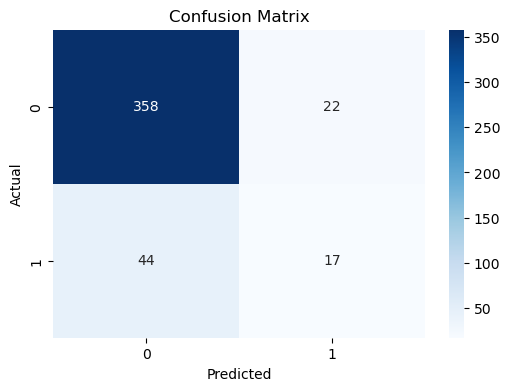

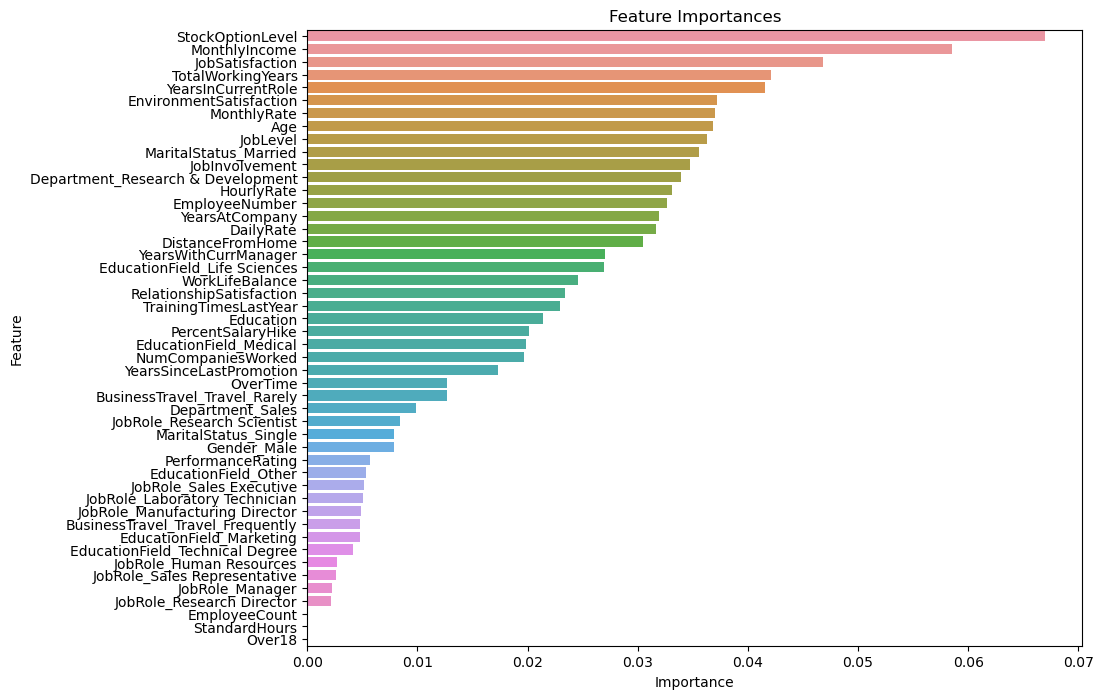

IntSlider(value=35, description='Age:', max=60, min=18)

IntText(value=5000, description='Monthly Income:')

Dropdown(description='Department:', options=('Sales', 'Research & Development', 'Human Resources'), value='Sal…

Button(description='Predict Attrition', style=ButtonStyle())

In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# dataset
df = pd.read_csv('datatable.csv')

# data preprocessing
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# encoding binary var
binary_cols = ['Attrition', 'OverTime']

label_encoder = LabelEncoder()
for col in binary_cols:
    df[col] = label_encoder.fit_transform(df[col])

# one hot encoding to multi-class var
multi_class_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
df = pd.get_dummies(df, columns=multi_class_cols, drop_first=True)

# non numeric data
df['Over18'] = df['Over18'].apply(lambda x: 1 if x == 'Y' else 0)

# prep features and target var
X = df.drop('Attrition', axis=1) 
y = df['Attrition'] 

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# SMOTE for balance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# check new class distro after applying SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# retrain random forest
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_resampled, y_resampled)

# evaluate model on test set
y_pred_resampled = rf_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_resampled))
print(classification_report(y_test, y_pred_resampled))

# plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_resampled), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# feat importance plot
feature_importances = rf_model.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances')
plt.show()

# UI section

# input widgets
age = widgets.IntSlider(value=35, min=18, max=60, description='Age:')
monthly_income = widgets.IntText(value=5000, description='Monthly Income:')
department = widgets.Dropdown(options=['Sales', 'Research & Development', 'Human Resources'], description='Department:')

# prediction button
button = widgets.Button(description="Predict Attrition")

# button click
def on_button_clicked(b):
    # dict with all input values on default
    input_data_dict = {
        'Age': age.value,
        'DailyRate': 1000,  # replace with default values or dynamic
        'DistanceFromHome': 10,
        'Education': 2,
        'EmployeeCount': 1,
        'EmployeeNumber': 1,
        'EnvironmentSatisfaction': 2,
        'HourlyRate': 60,
        'JobInvolvement': 3,
        'JobLevel': 2,
        'JobSatisfaction': 2,
        'MonthlyIncome': monthly_income.value,
        'MonthlyRate': 20000,
        'NumCompaniesWorked': 1,
        'OverTime': 0,
        'PercentSalaryHike': 15,
        'PerformanceRating': 3,
        'RelationshipSatisfaction': 2,
        'StandardHours': 80,
        'StockOptionLevel': 1,
        'TotalWorkingYears': 10,
        'TrainingTimesLastYear': 2,
        'WorkLifeBalance': 3,
        'YearsAtCompany': 5,
        'YearsInCurrentRole': 2,
        'YearsSinceLastPromotion': 1,
        'YearsWithCurrManager': 2,
        'BusinessTravel_Travel_Frequently': 0,
        'BusinessTravel_Travel_Rarely': 1,
        'Department_Research & Development': 1 if department.value == 'Research & Development' else 0,
        'Department_Sales': 1 if department.value == 'Sales' else 0,
        'EducationField_Life Sciences': 1,
        'EducationField_Marketing': 0,
        'EducationField_Medical': 0,
        'EducationField_Other': 0,
        'EducationField_Technical Degree': 0,
        'Gender_Male': 1,
        'JobRole_Human Resources': 0,
        'JobRole_Laboratory Technician': 0,
        'JobRole_Manager': 0,
        'JobRole_Manufacturing Director': 0,
        'JobRole_Research Director': 0,
        'JobRole_Research Scientist': 0,
        'JobRole_Sales Executive': 0,
        'JobRole_Sales Representative': 0,
        'MaritalStatus_Married': 0,
        'MaritalStatus_Single': 1,
    }

    # dataframe with xtrain
    input_df = pd.DataFrame([input_data_dict])

    # align input_df set missing values to 0
    input_df = input_df.reindex(columns=X_train.columns, fill_value=0)

    # trained model prediction
    probas = rf_model.predict_proba(input_df)[:, 1]
    threshold = 0.4
    prediction = (probas > threshold).astype(int)
    
    print(f"Predicted Attrition: {'Yes' if prediction[0] == 1 else 'No'}")

button.on_click(on_button_clicked)

# widgets
display(age, monthly_income, department, button)
